# NILL Agent Prediction Model

This notebook builds a machine learning model to predict which insurance agents will have zero sales in the coming month ("NILL" agents). By identifying these agents early, the company can take proactive measures to provide additional support or training.

## Overview
- Data loading and preparation
- Feature engineering
- Model training and evaluation
- Feature importance analysis
- Prediction on test set

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Preparation Functions

In [2]:
# Paths to data files
train_data_path = 'datasets/train_storming_round.csv'
test_data_path = 'datasets/test_storming_round.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data= pd.read_csv(test_data_path)

# Data preparation
# Convert date columns to datetime
date_columns = ['agent_join_month', 'first_policy_sold_month', 'year_month']
for col in date_columns:
    train_data[col] = pd.to_datetime(train_data[col], format='%m/%d/%Y')

# Calculate agent's experience (in months)
train_data['experience_months'] = ((train_data['year_month'].dt.year - train_data['agent_join_month'].dt.year) * 12 + 
                                    (train_data['year_month'].dt.month - train_data['agent_join_month'].dt.month))

# Calculate time to first sale (in months)
# For agents who haven't sold yet, use a large number
train_data['months_to_first_sale'] = np.where(
    pd.isna(train_data['first_policy_sold_month']),
    999,  # Large number for agents who haven't sold yet
    ((train_data['first_policy_sold_month'].dt.year - train_data['agent_join_month'].dt.year) * 12 + 
        (train_data['first_policy_sold_month'].dt.month - train_data['agent_join_month'].dt.month))
)

# Create a column to identify if an agent has already made their first sale
train_data['has_made_first_sale'] = ~pd.isna(train_data['first_policy_sold_month']).astype(int)

# Calculate proposal conversion rate
train_data['proposal_to_quotation_rate'] = np.where(
    train_data['unique_proposal'] > 0,
    train_data['unique_quotations'] / train_data['unique_proposal'],
    0
)

# Calculate quotation conversion rate
train_data['quotation_to_policy_rate'] = np.where(
    train_data['unique_quotations'] > 0,
    train_data['new_policy_count'] / train_data['unique_quotations'],
    0
)

# Calculate average policy value
train_data['avg_policy_value'] = np.where(
    train_data['new_policy_count'] > 0,
    train_data['ANBP_value'] / train_data['new_policy_count'],
    0
)

# Calculate average income per policy
train_data['avg_income_per_policy'] = np.where(
    train_data['new_policy_count'] > 0,
    train_data['net_income'] / train_data['new_policy_count'],
    0
)

# Calculate proposal activity in different time periods
train_data['proposal_activity_7d'] = train_data['unique_proposals_last_7_days'] / 7
train_data['proposal_activity_15d'] = train_data['unique_proposals_last_15_days'] / 15
train_data['proposal_activity_21d'] = train_data['unique_proposals_last_21_days'] / 21

# Calculate trend indicators for proposals
train_data['proposal_trend_short'] = train_data['proposal_activity_7d'] - train_data['proposal_activity_15d']
train_data['proposal_trend_med'] = train_data['proposal_activity_15d'] - train_data['proposal_activity_21d']

# Calculate cash payment ratio
train_data['cash_payment_ratio'] = np.where(
    train_data['new_policy_count'] > 0,
    train_data['number_of_cash_payment_policies'] / train_data['new_policy_count'],
    0
)

train_data['target'] = (train_data['new_policy_count'] == 0).astype(int)


## 3. Feature Engineering

In [3]:
# Create additional features that might be relevant for prediction

# Calculate ratio of proposals to customers
train_data['proposals_per_customer'] = np.where(
    train_data['unique_customers'] > 0,
    train_data['unique_proposal'] / train_data['unique_customers'],
    0
)

# Calculate ratio of quotations to customers
train_data['quotations_per_customer'] = np.where(
    train_data['unique_customers'] > 0,
    train_data['unique_quotations'] / train_data['unique_customers'],
    0
)

# Calculate how close they are to their latest customers
train_data['recent_customer_ratio'] = np.where(
    train_data['unique_customers'] > 0,
    train_data['unique_customers_last_7_days'] / train_data['unique_customers'],
    0
)

# Calculate policy holder ratio (if they have policy holders)
train_data['policyholder_ratio'] = np.where(
    train_data['new_policy_count'] > 0,
    train_data['number_of_policy_holders'] / train_data['new_policy_count'],
    0
)

# Calculate activity decay (reduction in activity over time periods)
train_data['proposal_decay_7_to_15'] = np.where(
    train_data['unique_proposals_last_15_days'] > 0,
    (train_data['unique_proposals_last_7_days'] / 7) / (train_data['unique_proposals_last_15_days'] / 15),
    0
)

train_data['quotation_decay_7_to_15'] = np.where(
    train_data['unique_quotations_last_15_days'] > 0,
    (train_data['unique_quotations_last_7_days'] / 7) / (train_data['unique_quotations_last_15_days'] / 15),
    0
)

# Create age group categories
train_data['age_group'] = pd.cut(train_data['agent_age'], bins=[0, 25, 35, 45, 55, 100], 
                            labels=['<25', '25-35', '35-45', '45-55', '55+'])

# Create experience group categories
train_data['experience_group'] = pd.cut(train_data['experience_months'], bins=[-1, 3, 6, 12, 24, 100], 
                                labels=['<3mo', '3-6mo', '6-12mo', '1-2yr', '>2yr'])

# Get month and year features
train_data['month'] = train_data['year_month'].dt.month
train_data['year'] = train_data['year_month'].dt.year



## 4. Data Preprocessing

In [4]:
# Define features to use
numeric_features = [
    'agent_age', 'experience_months', 'months_to_first_sale', 'has_made_first_sale',
    'unique_proposals_last_7_days', 'unique_proposals_last_15_days', 'unique_proposals_last_21_days',
    'unique_proposal', 'unique_quotations_last_7_days', 'unique_quotations_last_15_days',
    'unique_quotations_last_21_days', 'unique_quotations', 'unique_customers_last_7_days',
    'unique_customers_last_15_days', 'unique_customers_last_21_days', 'unique_customers',
    'new_policy_count', 'ANBP_value', 'net_income', 'number_of_policy_holders',
    'number_of_cash_payment_policies', 'proposal_to_quotation_rate', 'quotation_to_policy_rate',
    'avg_policy_value', 'avg_income_per_policy', 'proposal_activity_7d', 'proposal_activity_15d',
    'proposal_activity_21d', 'proposal_trend_short', 'proposal_trend_med', 'cash_payment_ratio',
    'proposals_per_customer', 'quotations_per_customer', 'recent_customer_ratio',
    'policyholder_ratio', 'proposal_decay_7_to_15', 'quotation_decay_7_to_15', 'month'
]

categorical_features = ['age_group', 'experience_group']

# Split features and target
X = train_data[numeric_features + categorical_features]
y = train_data['target'] 

# Replace inf and -inf with NaN, then fill NaN with median/mode
X = X.replace([np.inf, -np.inf], np.nan)

# Fill missing values for numeric columns with median
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# Fill missing values for categorical columns with mode
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Setup preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## 5. Model Training Functions

In [5]:

# Define models to try
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store results
results = {}
trained_models = {}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    
    # Create pipeline with preprocessing
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_val, y_pred))
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'pipeline': pipeline
    }
    
    trained_models[name] = pipeline

# Find the best model based on AUC
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"Best model: {best_model_name} with AUC: {results[best_model_name]['auc']:.4f}")

# Get the best model
best_model = trained_models[best_model_name]


Training RandomForest...
RandomForest - Accuracy: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2756
           1       1.00      1.00      1.00       306

    accuracy                           1.00      3062
   macro avg       1.00      1.00      1.00      3062
weighted avg       1.00      1.00      1.00      3062

Training GradientBoosting...
GradientBoosting - Accuracy: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2756
           1       1.00      1.00      1.00       306

    accuracy                           1.00      3062
   macro avg       1.00      1.00      1.00      3062
weighted avg       1.00      1.00      1.00      3062

Training XGBoost...
XGBoost - Accuracy: 0.9997, AUC: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2756
           1       1.00      

## 6. Feature Importance Analysis

In [9]:
def find_feature_importance(model, numeric_features, categorical_features, preprocessor):
    """
    Determine the importance of features in the model
    """
    # Extract feature names
    feature_names = numeric_features.copy()
    
    # Get one-hot encoded feature names for categorical features
    if hasattr(preprocessor.transformers_[1][1]['onehot'], 'get_feature_names_out'):
        ohe_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    else:
        ohe_features = [f"{col}_{val}" for col in categorical_features for val in preprocessor.transformers_[1][1]['onehot'].categories_[categorical_features.index(col)]]
    
    feature_names.extend(ohe_features)
    
    # Extract the classifier
    if 'classifier' in model.named_steps:
        classifier = model.named_steps['classifier']
    else:
        return None, None
    
    # Get feature importances
    importances = None
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    
    if importances is not None:
        # Create DataFrame of feature importances
        feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importances = feature_importances.sort_values('Importance', ascending=False)
        
        return feature_importances, importances
    else:
        return None, None
    
feature_importances, _ = find_feature_importance(best_model, numeric_features, categorical_features, preprocessor)

print("\nTop 10 factors affecting agent performance:")
for i, (feature, importance) in enumerate(zip(feature_importances['Feature'].head(10), 
                                                feature_importances['Importance'].head(10))):
    print(f"{i+1}. {feature}: {importance:.4f}")


Top 10 factors affecting agent performance:
1. ANBP_value: 0.2222
2. avg_income_per_policy: 0.2087
3. quotation_to_policy_rate: 0.1695
4. new_policy_count: 0.1571
5. avg_policy_value: 0.1339
6. cash_payment_ratio: 0.0570
7. policyholder_ratio: 0.0380
8. number_of_policy_holders: 0.0102
9. number_of_cash_payment_policies: 0.0012
10. unique_customers: 0.0002


## 7. Visualization Functions

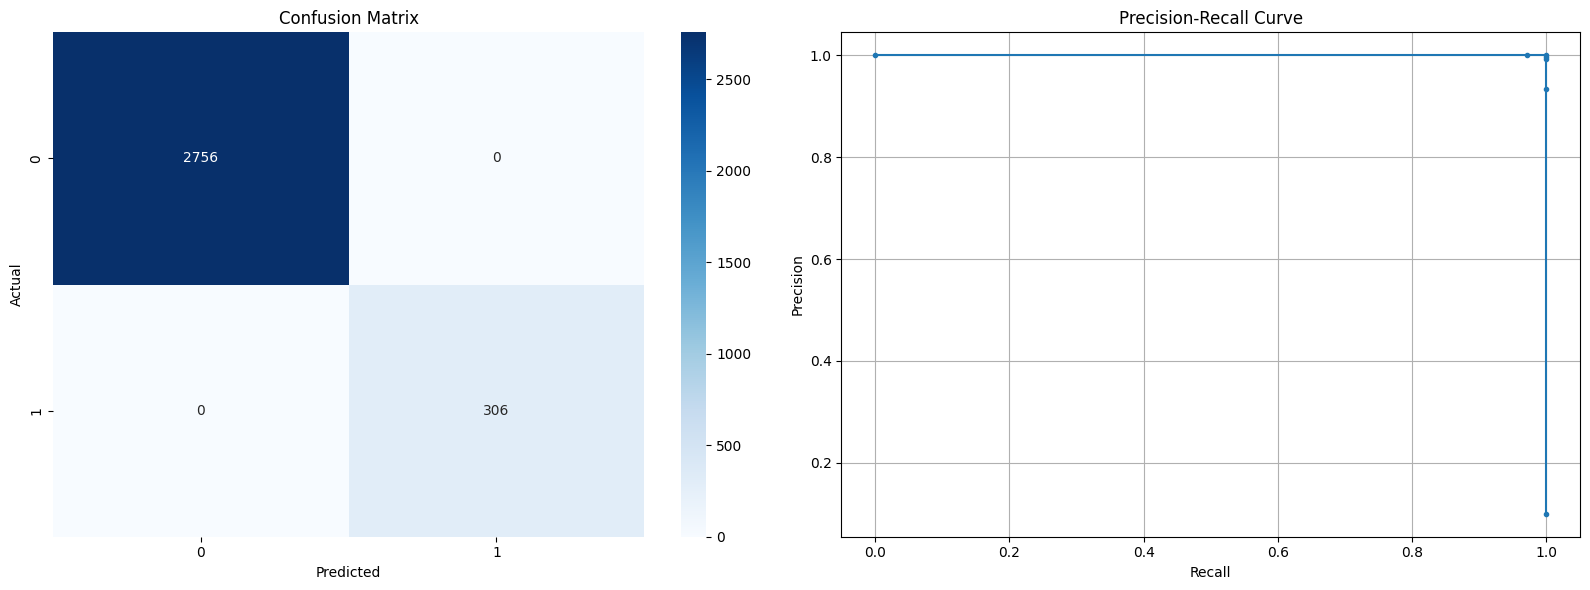

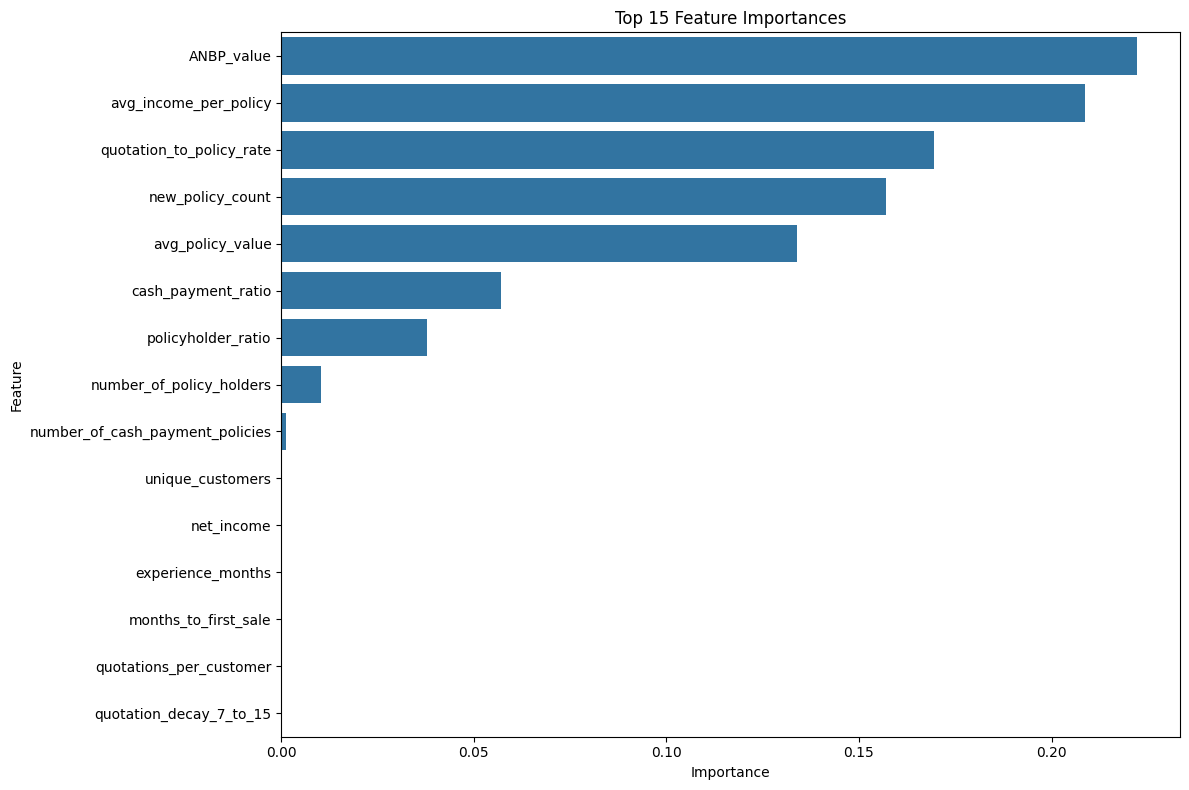

In [7]:
def visualize_results(model, X_val, y_val, feature_importances=None):
    """
    Visualize model results
    """
    # Predict on validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Create figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    ax[1].plot(recall, precision, marker='.')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance if available
    if feature_importances is not None and len(feature_importances) > 0:
        plt.figure(figsize=(12, 8))
        top_features = feature_importances.head(15)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()

visualize_results(best_model, X_val, y_val, feature_importances)

# Personalized Action Plans for Agents

The following action plans have been designed based on the analysis of agents' performance. These plans target specific areas where agents may need improvement. By addressing these issues, agents can improve their overall sales performance and achieve better results.

## Action Plans Based on Agent Performance

### 1. For Agents with Low Proposal Activity
These agents need to focus on increasing their outreach to potential customers.

**Action Plan:**
- **Daily Goal**: Contact at least 5 potential customers.
- **Weekly Training**: Attend training on prospecting techniques.
- **Mentorship**: Pair with a high-performing mentor for shadowing to learn best practices.

---

### 2. For Agents with Good Proposals but Low Conversion to Quotations
These agents are good at generating proposals but struggle with converting them into quotations.

**Action Plan:**
- **Presentation Skills**: Focus on improving presentation skills to create more compelling proposals.
- **Product Knowledge**: Review product knowledge training to ensure they are able to highlight the right features.
- **Objection Handling**: Practice objection handling scenarios to close more proposals.

---

### 3. For Agents with Good Quotations but Low Policy Conversion
These agents have strong quotations but face challenges in converting those to policies.

**Action Plan:**
- **Closing Techniques**: Provide training on advanced closing techniques to help agents seal the deal.
- **Review Product Fit**: Revisit pricing and product fit to ensure that the offering is appealing to the clients.
- **Follow-up System**: Implement a system for regular follow-ups on pending quotations to convert more leads.

---

### 4. For Agents with Inconsistent Activity (High Decay Metrics)
These agents demonstrate fluctuating performance, and more consistent effort is needed to stabilize their output.

**Action Plan:**
- **Daily Activity Tracking**: Implement daily activity tracking to monitor progress and maintain consistent performance.
- **Set Weekly Targets**: Set weekly rather than monthly targets to keep agents motivated and on track.
- **Regular Check-ins**: Schedule regular check-ins with managers to offer guidance and encouragement.

---

## Conclusion
By applying these personalized action plans, agents will receive targeted support to enhance their performance. Regular monitoring of progress and adapting the action plans based on evolving needs will be essential for continual improvement.
